In [ ]:
#to be run only when on Google Colab
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

In [1]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
!pip install tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
    """
      Load the data to a pandas dataframe.
      Dataframe Columns:
      title
      para_index
      context
      q_index
      q_id
      q_isimpossible
      q_question
      q_anscount - number of answers
      q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
    """
    result = []
    for pdata in data['data']:
        for para in pdata['paragraphs']:
            for q in para['qas']:
                result.append({
                                'title' : pdata['title'],
                                'context' : para['context'],
                                'q_id' : q['id'],
                                'q_isimpossible' : q['is_impossible'],
                                'q_question' : q['question'],
                                'q_anscount' : len(q['answers']),
                                'q_answers' : [a for a in q['answers']],
                                'q_answers_text': [a.get("text") for a in q['answers']],
                                'context_lowercase': para['context'].lower(),
                                'q_question_lowercase' : q['question'].lower(),
                                'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']]
                               })
    return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
    """
    Download a file from google drive with the shared link
    """ 
    data = load_json_file(filename)
    return convert_to_pd(data)

In [2]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [5]:
context_maxlen = 250
question_maxlen = 20
answer_maxlen = 15
ndim = 100

In [6]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def calc_answer_span(context,answer):
    
    ans_len = len(answer)
    
    if ans_len!=0 and answer[0] in context:
        indices = [i for i, x in enumerate(context) if x == answer[0]]
        try:
            if(len(indices)>1):
                start = [i for i in indices if (context[i:i+ans_len] == answer) ]
                end = start[0] + ans_len - 1
                return (start[0],end)
            else:
                start = context.index(answer[0])
                end = start + ans_len - 1
                return (start,end)
        except:
            return (-1,-1)
    else:
        return (-1,-1)


def vectorize_data(tokenizer_obj,train_lists):
    qid_original = train_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_span = [calc_answer_span(context_seq[i],answer_seq[i]) for i,x in enumerate(context_seq)]
    answer_start_index = [item[0] for item in answer_span]
    answer_end_index =  [item[1] for item in answer_span]
    answer_start_seq = []
    answer_end_seq = []
    for i,x in enumerate(answer_start_index):
        start = np.zeros(context_maxlen,dtype = "int32")
        end   = np.zeros(context_maxlen,dtype = "int32")
        #last space reserved for the question where there are no answers
        if (answer_start_index[i] < context_maxlen and answer_start_index[i] != -1):
            start[answer_start_index[i]] = 1
        if (answer_end_index[i] < context_maxlen and answer_end_index[i] != -1):
            end[answer_end_index[i]] = 1
        answer_start_seq.append(start)
        answer_end_seq.append(end)
        
    answer_input_seq = [i for i in answer_seq]
    answer_target_seq = answer_input_seq
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    #context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    answer_start_seq_padded = pad_sequences(answer_start_seq,context_maxlen,padding='post', truncating='post') 
    answer_end_seq_padded = pad_sequences(answer_end_seq,context_maxlen,padding='post', truncating='post')
    #context_match_question = []
    #for i,a in enumerate(context_seq_padded):
    #    exact = [[1]if ecw in question_seq_padded[i] and ecw !=0 else [0] for ecw in a]
    #    context_match_question.append(exact)
    
    #context_match_question_padded = np.array(context_match_question)
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    qid = [qid_original[i] for i in indices]
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible = answer_impossible[indices]
    answer_start_seq_padded = answer_start_seq_padded[indices]
    answer_end_seq_padded = answer_end_seq_padded[indices]
    #context_match_question_padded = context_match_question_padded[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_qid = qid[:train_samples]
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible[:train_samples]
    train_answer_start_seq_padded = answer_start_seq_padded[:train_samples]
    train_answer_end_seq_padded = answer_end_seq_padded[:train_samples]
    #train_context_match_question_padded = context_match_question_padded[:train_samples]
    val_qid = qid[train_samples:end_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible[train_samples:end_samples]
    val_answer_start_seq_padded = answer_start_seq_padded[train_samples:end_samples]
    val_answer_end_seq_padded = answer_end_seq_padded[train_samples:end_samples]
    #val_context_match_question_padded = context_match_question_padded[train_samples:end_samples]
    return (train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            train_answer_start_seq_padded,train_answer_end_seq_padded,
            #train_context_match_question_padded,
            val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,
            val_answer_start_seq_padded,val_answer_end_seq_padded
            #,val_context_match_question_padded
           )

train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,\
train_answer_start_seq_padded,train_answer_end_seq_padded,\
val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,\
val_answer_start_seq_padded,val_answer_end_seq_padded\
= vectorize_data(tokenizer_obj,train_lists)
print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [7]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [8]:
embedding_matrix.shape

(88702, 100)

In [9]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.WSTART = tf.keras.layers.Dense(2*self.num_unit_gru)
        self.WEND = tf.keras.layers.Dense(2*self.num_unit_gru)        
    
    def call(self,
             question,
             context):
        
        context = tf.transpose(context,[0,2,1])
        ################ start prediction logit ######################
        start = self.WSTART(question)
        hidden_start_time_axis = tf.expand_dims(start, 1)
        
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,context),axis=1)
        start_logit = tf.math.exp(start_logit)
            
        ################ end prediction logit ######################
        end = self.WEND(question)

        hidden_end_time_axis = tf.expand_dims(end, 1)
        
        # squeeze remooves time slice we added before
        # final shape = (batch_size,decoder_timesteps)
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,context),axis=1)
        end_logit = tf.math.exp(end_logit)
        
        
        return start_logit,end_logit 

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(
                                                layers.GRU(self.num_unit_gru,
                                                           dropout=self.dropout_rate,
                                                           recurrent_dropout= self.dropout_rate,
                                                           recurrent_initializer='glorot_uniform',
                                                           return_sequences=True,
                                                           kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight),
                                                           bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight)),
                                                           merge_mode='concat',
                                                           name='Context_Bid_Layer'+str(i))
                                              )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.question_output_layers.append(layers.Bidirectional(
                                                 layers.GRU(self.num_unit_gru,
                                                            dropout=self.dropout_rate,
                                                            recurrent_dropout= self.dropout_rate,
                                                            recurrent_initializer='glorot_uniform',
                                                            return_sequences=True,
                                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight),
                                                            bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight)),
                                                             merge_mode='concat',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
            
        self.question_attention_layer = layers.Dense(1)
        #Episodic Memory 
        #self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        #self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        #self.episodic_score_layer = layers.Dense(1)
        #Self alignment
        self.Align_W1 = tf.keras.layers.Dense(1,activation="relu")
        self.Align_W2 = tf.keras.layers.Dense(1,activation="relu")
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        #self alignment
        context_relu = self.Align_W1(context_embeddings)
        question_relu = self.Align_W2(question_embeddings)
        self_align_logits = tf.matmul(context_relu,tf.transpose(question_relu,[0,2,1]))
        self_align_scores = tf.nn.softmax(self_align_logits)
        self_align_embeddings = tf.matmul(self_align_scores,question_embeddings)
        context_concat_embeddings = tf.concat(values=[context_embeddings,self_align_embeddings],axis=-1)
        
        #print("context_embeddings.shape:",context_embeddings.shape)
        #print("question_embeddings.shape:",question_embeddings.shape)
        #print("context_relu.shape:",context_relu.shape)
        #print("question_relu.shape:",question_relu.shape)
        #print("self_align_logits.shape:",self_align_logits.shape)
        #print("self_align_scores.shape:",self_align_scores.shape)
        #print("self_align_embeddings.shape:",self_align_embeddings.shape)
        #print("context_concat_embeddings.shape:",context_concat_embeddings.shape)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_concat_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        
        #Calculate the self attention for question        
        question_score = self.question_attention_layer(question_outputs)
        # attention_weights shape == (batch_size, max_length, 1)
        question_attention_weights = tf.nn.softmax(question_score, axis=1)
        question_outputs = question_attention_weights * question_outputs
        question_outputs = tf.reduce_sum(question_outputs, axis=1)
        
        #Episodic Memory 
        #m = tf.identity(question_outputs)
        #for i in range(self.num_episodes):
        #    m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    c_mul_q = layers.multiply([context_outputs,q_increased])
        #    c_mul_m = layers.multiply([context_outputs,m_increased])
        #    c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
        #    c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
        #    c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
        #                        context_outputs,
        #                        transpose_b=True)
        #    c_dot_q = layers.Permute((2,1))(c_dot_q)
        #    c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
        #                        context_outputs,transpose_b=True)
        #    c_dot_m = layers.Permute((2,1))(c_dot_m)
        #    z = tf.concat([context_outputs,
        #                            m_increased,
        #                            q_increased,
        #                            c_mul_q,
        #                            c_mul_m,
        #                            c_minus_q,
        #                            c_minus_m,
        #                            c_dot_q,
        #                            c_dot_m],axis=-1)
        #    score = self.episodic_score_layer(self.episodic_tanh_layer(z))
        #    attention_weights = tf.nn.softmax(score, axis=1)
        #    m_value = attention_weights * context_outputs
        #    m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        #concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    #feasibility_episodic_memory_input = Input(shape=(num_unit_gru,), name="FeasibilityEpisodicMemoryInput")
    #feasibility_start_logits_input = Input(shape=(max_context_length,),name="FeasibilityStartLogitInput")
    #feasibility_end_logits_input = Input(shape=(max_context_length),name="FeasibilityEndLogitInput")
    feasibility_context_input = Input(shape=(None,2*num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(2*num_unit_gru,),name='feasibilityQuestion_Input')
    #create attention between Context and Question
    q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
    attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
                                                          feasibility_context_input])
    attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
    #create Episodic memory 
    #Episodic Memory 
    episodic_weight_layer = layers.Dense(2*num_unit_gru,use_bias=False)
    episodic_tanh_layer = layers.Dense(num_episodic_network_unit,activation='tanh')
    episodic_score_layer = layers.Dense(1)
    m = tf.identity(feasibility_question_input)
    for i in range(num_episodes):
        m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        q_increased = tf.tile(tf.keras.backend.expand_dims(feasibility_question_input,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        c_mul_q = layers.multiply([feasibility_context_input,q_increased])
        c_mul_m = layers.multiply([feasibility_context_input,m_increased])
        c_minus_q =tf.keras.backend.abs(layers.subtract([feasibility_context_input,q_increased]))
        c_minus_m = tf.keras.backend.abs(layers.subtract([feasibility_context_input,m_increased]))
        c_dot_q = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(feasibility_question_input),1), 
                            feasibility_context_input,
                            transpose_b=True)
        c_dot_q = layers.Permute((2,1))(c_dot_q)
        c_dot_m = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(m),1), 
                            feasibility_context_input,transpose_b=True)
        c_dot_m = layers.Permute((2,1))(c_dot_m)
        z = tf.concat([feasibility_context_input,
                                m_increased,
                                q_increased,
                                c_mul_q,
                                c_mul_m,
                                c_minus_q,
                                c_minus_m,
                                c_dot_q,
                                c_dot_m],axis=-1)
        score = episodic_score_layer(episodic_tanh_layer(z))
        attention_weights = tf.nn.softmax(score, axis=1)
        m_value = attention_weights * feasibility_context_input
        m = tf.reduce_sum(m_value, axis=1)
    
    
    #feasibility_dense_input = tf.concat([m,
    #                                     feasibility_start_logits_input,
    #                                     feasibility_end_logits_input],
    #                                    axis=-1)
    feasibility_dense_input = tf.concat([m,
                                         attentionContextQuestionReduced],
                                        axis=-1)
    for i in range(num_dense_layers_feasibility):        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_question_input,
                               feasibility_context_input],
                               feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [11]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=0)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    
    for i in range(start_position[0],end_position[0]+1):
        sampled_token_index = context_input_seq[0,i]
        if sampled_token_index == 0:
            sampled_char = ""
        else:
            sampled_char = id_vocab[sampled_token_index]
        if i == start_position[0]:
            decoded_sentence += sampled_char
        else:
            decoded_sentence += " "+sampled_char
    return decoded_sentence

In [12]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 3,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 2,
                                  'num_episodic_network_unit': 96,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 4,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 100,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 128,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 64,
                                  'num_layers_gru': 4,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 80,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment7': {'num_unit_gru': 128,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 2,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 3,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 2,

In [14]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        #feasibility_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.BinaryCrossentropy(),
        #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
        #                           )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            #feasibility_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.BinaryCrossentropy(),
            #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
            #                           )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    @tf.function
    def answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = answer_loss_object(real_start,pred_start)
        end_loss = answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        batch_loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss
            train_acc_metric(targ_start,start_logits)
            train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)
        loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
        batch_loss = loss
        val_acc_metric(targ_start,start_logits)
        val_acc_metric(targ_end,end_logits)
        
        return batch_loss
    #Create batches for training only include where its possible to answer
    #
    #c = b==1
    #a[c][:3]
    train_ans_cond = np.any(train_answer_start_seq_padded == 1,
                            axis=1) & np.any(train_answer_end_seq_padded==1,
                                             axis=1)
    
    #train_answer_impossible==0
    val_ans_cond = np.any(val_answer_start_seq_padded == 1,
                            axis=1) & np.any(val_answer_end_seq_padded==1,
                                             axis=1)
    #val_answer_impossible==0
    #make sure that training samples and validation samples are divisible by 1024
    num_training_samples_upd = int((train_context_padded_seq[train_ans_cond][:num_training_samples].shape[0]//1024)
                                   *1024)
    
    num_validation_samples_upd = int((val_context_padded_seq[val_ans_cond][:num_validation_samples].shape[0]//1024)
                                   *1024)
    TRAIN_BUFFER_SIZE = train_context_padded_seq[train_ans_cond][:num_training_samples_upd].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[val_ans_cond][:num_validation_samples_upd].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[train_ans_cond][:num_training_samples_upd],
                                                        train_question_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_input_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_target_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_impossible[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_start_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_end_seq_padded[train_ans_cond][:num_training_samples_upd]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[val_ans_cond][:num_validation_samples_upd],
                                                      val_question_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_input_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_target_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_impossible[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_start_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_end_seq_padded[val_ans_cond][:num_validation_samples_upd]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'categorical_accuracy':[],
                            'val_loss':[],
                            'val_categorical_accuracy':[]}
    print("\nTraining the answer model:")
    #tqdm.write("\nTraining the answer model:")
    #Value to store best validation accuracy
    max_answer_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples_upd//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_start_seq_padded,
                                           batch_train_answer_end_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples_upd//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_start_seq_padded,
                                         batch_val_answer_end_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_categorical_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_answer_val_accuracy:
            max_answer_val_accuracy = epoch_val_accuracy
            answer_model.save_weights(ExperimentNo+'span2_model_answer_model.h5')
            encoder_model.save_weights(ExperimentNo+'span2_model_encoder_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
        
    #answer_model.save_weights(ExperimentNo+'span2_model_answer_model.h5')
    #encoder_model.save_weights(ExperimentNo+'span2_model_encoder_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    #load the best encoder model weights
    encoder_model.load_weights(ExperimentNo+'span2_model_encoder_model.h5')
    #Create batches for training including where answer is impossible
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}
    print("Training the Feasibility model:")
    #tqdm.write("\nTraining the Feasibility model:")
    #Value to store best validation accuracy
    max_feasibility_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_feasibility_val_accuracy:
            max_feasibility_val_accuracy = epoch_val_accuracy
            feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('\nTime taken for epoch {} sec'.format(time.time() - start))
    
    #feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)
    
    """
        
    train_question_output,\
    train_context_output = encoder_model(train_context_padded_seq[:num_training_samples],
                                         train_question_seq_padded[:num_training_samples])
    
    train_start_logits,train_end_logits = answer_model(train_question_output,train_context_output)
    
    val_question_output,\
    val_context_output = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                           val_question_seq_padded[:num_validation_samples])
    
    val_start_logits,val_end_logits = answer_model(val_question_output,val_context_output)
    
    
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([train_question_output,
                                                       train_context_output,
                                                       train_start_logits,
                                                       train_end_logits],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([val_question_output,
                                                              val_context_output,
                                                              val_start_logits,
                                                              val_end_logits],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    """
    

In [15]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, 
                                                                           reduction='none')
    @tf.function
    def inference_answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = inference_answer_loss_object(real_start,pred_start)
        end_loss = inference_answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def inference_answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += inference_answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss/inp.shape[0]
            #train_acc_metric(targ_start,start_logits)
            #train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

        
        
    
    
    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_start_seq_padded[:1],
                              train_answer_end_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights(ExperimentNo+'span2_model_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'span2_model_encoder_model.h5')
    inference_feasibility_model.load_weights(ExperimentNo+'span2_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [16]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too
for i in range(8):
    tpu_enabled_flag = 0
    if tpu_enabled_flag ==0:
        number_of_epochs = 25
    else:
        number_of_epochs = 35
    run_experiments(Experiment_Dic=Experiment_Dic,
                Experiment_No=i,
                embedding_matrix=embedding_matrix,
                ndim = ndim,
                tpu_enabled=tpu_enabled_flag,
                num_training_samples=1024*60,
                num_validation_samples = 1024*6,
                num_epochs = number_of_epochs,
                batch_size = 128)

[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 7.1842 Train Accuracy 0.1646


[Validating Answer]: 100%|██████████| 48/48 [00:17<00:00,  2.81it/s]


Epoch 1 - Validation Loss 6.2612 Validation Accuracy 0.2275


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 1
Time taken for epoch 620.9517712593079 sec

Epoch 2/30
Epoch 2 - Train Loss 5.8576 Train Accuracy 0.2607


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.28it/s]


Epoch 2 - Validation Loss 5.7315 Validation Accuracy 0.2651


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 633.2982416152954 sec

Epoch 3/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 5.3843 Train Accuracy 0.3065


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.41it/s]


Epoch 3 - Validation Loss 5.5458 Validation Accuracy 0.2880


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 607.851203918457 sec

Epoch 4/30
Epoch 4 - Train Loss 5.0434 Train Accuracy 0.3408


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 4 - Validation Loss 5.3630 Validation Accuracy 0.3066


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 595.2682662010193 sec

Epoch 5/30
Epoch 5 - Train Loss 4.7643 Train Accuracy 0.3716


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 5 - Validation Loss 5.2998 Validation Accuracy 0.3161


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 595.7650699615479 sec

Epoch 6/30
Epoch 6 - Train Loss 4.5148 Train Accuracy 0.3995


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 6 - Validation Loss 5.2881 Validation Accuracy 0.3201


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 596.7917110919952 sec

Epoch 7/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 4.2906 Train Accuracy 0.4239


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 7 - Validation Loss 5.3151 Validation Accuracy 0.3302


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 595.963348865509 sec

Epoch 8/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 4.0748 Train Accuracy 0.4511


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 8 - Validation Loss 5.2921 Validation Accuracy 0.3321


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 8
Time taken for epoch 596.0829191207886 sec

Epoch 9/30
Epoch 9 - Train Loss 3.8702 Train Accuracy 0.4740


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 5.2931 Validation Accuracy 0.3298
Time taken for epoch 593.5665078163147 sec

Epoch 10/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 3.6750 Train Accuracy 0.4987


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 10 - Validation Loss 5.5606 Validation Accuracy 0.3326


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 595.8635396957397 sec

Epoch 11/30
Epoch 11 - Train Loss 3.4919 Train Accuracy 0.5202


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 5.4859 Validation Accuracy 0.3306
Time taken for epoch 593.8228466510773 sec

Epoch 12/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 3.3001 Train Accuracy 0.5444


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 5.8466 Validation Accuracy 0.3247
Time taken for epoch 595.1731908321381 sec

Epoch 13/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 3.1316 Train Accuracy 0.5654


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 5.9399 Validation Accuracy 0.3197
Time taken for epoch 594.2577230930328 sec

Epoch 14/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 2.9543 Train Accuracy 0.5871


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 6.2820 Validation Accuracy 0.3232
Time taken for epoch 594.0122380256653 sec

Epoch 15/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 2.7978 Train Accuracy 0.6077


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 6.3257 Validation Accuracy 0.3197
Time taken for epoch 594.3151988983154 sec

Epoch 16/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 2.6567 Train Accuracy 0.6251


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 6.4404 Validation Accuracy 0.3149
Time taken for epoch 593.7514126300812 sec

Epoch 17/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 2.5227 Train Accuracy 0.6429


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 6.8898 Validation Accuracy 0.3108
Time taken for epoch 593.1465430259705 sec

Epoch 18/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 2.3987 Train Accuracy 0.6581


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 6.9668 Validation Accuracy 0.3075
Time taken for epoch 593.9669561386108 sec

Epoch 19/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 2.2573 Train Accuracy 0.6777


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 7.2981 Validation Accuracy 0.3065
Time taken for epoch 593.8086805343628 sec

Epoch 20/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 2.1604 Train Accuracy 0.6899


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 8.0183 Validation Accuracy 0.3083
Time taken for epoch 593.9313757419586 sec

Epoch 21/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 2.0581 Train Accuracy 0.7032


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 7.9040 Validation Accuracy 0.2995
Time taken for epoch 593.6324074268341 sec

Epoch 22/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 1.9681 Train Accuracy 0.7151


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 8.7269 Validation Accuracy 0.2988
Time taken for epoch 593.6292426586151 sec

Epoch 23/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 1.9150 Train Accuracy 0.7228


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 8.5342 Validation Accuracy 0.2991
Time taken for epoch 593.7896914482117 sec

Epoch 24/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 2.4048 Train Accuracy 0.6666


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 7.7054 Validation Accuracy 0.2969
Time taken for epoch 594.4957993030548 sec

Epoch 25/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 1.9685 Train Accuracy 0.7122


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 25 - Validation Loss 8.7465 Validation Accuracy 0.3031
Time taken for epoch 593.7565174102783 sec

Epoch 26/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26 - Train Loss 1.6437 Train Accuracy 0.7588


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 26 - Validation Loss 9.5749 Validation Accuracy 0.2970
Time taken for epoch 594.0374736785889 sec

Epoch 27/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27 - Train Loss 1.5640 Train Accuracy 0.7691


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 27 - Validation Loss 9.8430 Validation Accuracy 0.2934
Time taken for epoch 594.5733432769775 sec

Epoch 28/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28 - Train Loss 1.5243 Train Accuracy 0.7746


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 28 - Validation Loss 10.1081 Validation Accuracy 0.2887
Time taken for epoch 593.4963827133179 sec

Epoch 29/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29 - Train Loss 1.4947 Train Accuracy 0.7785


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 29 - Validation Loss 10.4858 Validation Accuracy 0.2915
Time taken for epoch 592.5835733413696 sec

Epoch 30/30


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30 - Train Loss 1.4439 Train Accuracy 0.7871


[Validating Answer]: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]


Epoch 30 - Validation Loss 10.7416 Validation Accuracy 0.2910
Time taken for epoch 593.2671568393707 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6241 Train Accuracy 0.6675


[Validating Feasibility]: 100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Epoch 1 - Validation Loss 0.6272 Validation Accuracy 0.6621
Best Epoch so far! Epoch No 1
Time taken for epoch 696.1553111076355 sec

Epoch 2/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6156 Train Accuracy 0.6701


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch 2 - Validation Loss 0.6207 Validation Accuracy 0.6626
Best Epoch so far! Epoch No 2
Time taken for epoch 688.4054889678955 sec

Epoch 3/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6079 Train Accuracy 0.6740


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch 3 - Validation Loss 0.6162 Validation Accuracy 0.6649
Best Epoch so far! Epoch No 3
Time taken for epoch 688.9115092754364 sec

Epoch 4/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6016 Train Accuracy 0.6779


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch 4 - Validation Loss 0.6166 Validation Accuracy 0.6681
Best Epoch so far! Epoch No 4
Time taken for epoch 689.4157266616821 sec

Epoch 5/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.5966 Train Accuracy 0.6809


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5 - Validation Loss 0.6150 Validation Accuracy 0.6639
Time taken for epoch 689.8026390075684 sec

Epoch 6/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.5952 Train Accuracy 0.6824


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch 6 - Validation Loss 0.6128 Validation Accuracy 0.6699
Best Epoch so far! Epoch No 6
Time taken for epoch 690.6022531986237 sec

Epoch 7/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.5873 Train Accuracy 0.6871


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch 7 - Validation Loss 0.6144 Validation Accuracy 0.6720
Best Epoch so far! Epoch No 7
Time taken for epoch 691.8325233459473 sec

Epoch 8/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.5820 Train Accuracy 0.6895


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6155 Validation Accuracy 0.6660
Time taken for epoch 692.246883392334 sec

Epoch 9/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.5755 Train Accuracy 0.6940


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6170 Validation Accuracy 0.6608
Time taken for epoch 690.2361690998077 sec

Epoch 10/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.5684 Train Accuracy 0.6982


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6166 Validation Accuracy 0.6672
Time taken for epoch 690.6849765777588 sec

Epoch 11/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.5618 Train Accuracy 0.7030


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6237 Validation Accuracy 0.6605
Time taken for epoch 691.1258976459503 sec

Epoch 12/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.5542 Train Accuracy 0.7088


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6324 Validation Accuracy 0.6657
Time taken for epoch 688.3894276618958 sec

Epoch 13/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.5481 Train Accuracy 0.7101


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6296 Validation Accuracy 0.6660
Time taken for epoch 690.6882717609406 sec

Epoch 14/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.5404 Train Accuracy 0.7159


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6354 Validation Accuracy 0.6652
Time taken for epoch 690.4001507759094 sec

Epoch 15/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.5336 Train Accuracy 0.7224


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6369 Validation Accuracy 0.6655
Time taken for epoch 690.8377411365509 sec

Epoch 16/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.5239 Train Accuracy 0.7274


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6471 Validation Accuracy 0.6644
Time taken for epoch 690.8036665916443 sec

Epoch 17/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.5166 Train Accuracy 0.7325


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6670 Validation Accuracy 0.6590
Time taken for epoch 714.8952324390411 sec

Epoch 18/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.5052 Train Accuracy 0.7385


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6498 Validation Accuracy 0.6592
Time taken for epoch 710.6078231334686 sec

Epoch 19/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.5026 Train Accuracy 0.7384


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6781 Validation Accuracy 0.6639
Time taken for epoch 711.7316093444824 sec

Epoch 20/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.4933 Train Accuracy 0.7472


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6853 Validation Accuracy 0.6450
Time taken for epoch 690.7018437385559 sec

Epoch 21/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.4816 Train Accuracy 0.7545


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.7226 Validation Accuracy 0.6335
Time taken for epoch 690.4973692893982 sec

Epoch 22/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.4738 Train Accuracy 0.7585


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.7482 Validation Accuracy 0.6538
Time taken for epoch 691.3275060653687 sec

Epoch 23/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.4637 Train Accuracy 0.7663


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.7443 Validation Accuracy 0.6512
Time taken for epoch 697.4380943775177 sec

Epoch 24/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.4586 Train Accuracy 0.7694


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.7713 Validation Accuracy 0.6421
Time taken for epoch 701.3276896476746 sec

Epoch 25/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.4469 Train Accuracy 0.7753


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 25 - Validation Loss 0.7902 Validation Accuracy 0.6229
Time taken for epoch 700.9065957069397 sec

Epoch 26/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26 - Train Loss 0.4356 Train Accuracy 0.7831


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 26 - Validation Loss 0.7918 Validation Accuracy 0.6421
Time taken for epoch 705.0374050140381 sec

Epoch 27/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27 - Train Loss 0.4321 Train Accuracy 0.7849


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 27 - Validation Loss 0.7977 Validation Accuracy 0.6315
Time taken for epoch 708.2402844429016 sec

Epoch 28/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28 - Train Loss 0.4192 Train Accuracy 0.7923


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 28 - Validation Loss 0.8412 Validation Accuracy 0.6208
Time taken for epoch 712.4292006492615 sec

Epoch 29/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29 - Train Loss 0.4118 Train Accuracy 0.7965


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 29 - Validation Loss 0.8966 Validation Accuracy 0.6390
Time taken for epoch 705.5162160396576 sec

Epoch 30/30


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30 - Train Loss 0.4032 Train Accuracy 0.8007


[Validating Feasibility]: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch 30 - Validation Loss 0.8722 Validation Accuracy 0.6370
Time taken for epoch 702.8474071025848 sec



In [17]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=0,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [18]:
#Some Examples from Training Set
for seq_index in range(500,510):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",train_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: which former enemy wanted an alliance with the romans
Question Infeasible to answer prediction: [[0.06843323]]
Question Infeasible to answer actual value [0]
Predicted Answer: philip
Actual answer: philip
question: by what year did japanese strategists expand their concept of the greater east asia co prosperity sphere
Question Infeasible to answer prediction: [[0.02750778]]
Question Infeasible to answer actual value [0]
Predicted Answer: 1940
Actual answer: 1940
question: what did the british railway stop using in 1954
Question Infeasible to answer prediction: [[0.20879762]]
Question Infeasible to answer actual value [1]
Predicted Answer: telescopes instead of atomic clocks
Actual answer: 
question: how old is the primitive plying insect found by the university
Question Infeasible to answer prediction: [[0.09170309]]
Question Infeasible to answer actual value [0]
Predicted Answer: 300 million year
Actual answer: 300 million year old
question: what role did women fill in the c

In [20]:
#Some examples from validation set
for seq_index in range(800,810):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    context_input_seq = val_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = val_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in val_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",val_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in val_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what failed to rally the supporters of the failed revolt
Question Infeasible to answer prediction: [[0.06257592]]
Question Infeasible to answer actual value [1]
Predicted Answer: the hashimiyya movement
Actual answer: 
question: how long is the term for vice chair of the supervisory board
Question Infeasible to answer prediction: [[0.16797975]]
Question Infeasible to answer actual value [0]
Predicted Answer: five years
Actual answer: chosen from among the members of the ecb s executive board
question: what does not apply to any branch of government
Question Infeasible to answer prediction: [[0.16340752]]
Question Infeasible to answer actual value [1]
Predicted Answer: checks and balances apply to the judicial branch
Actual answer: 
question: what is the name of the famous bank located in boston
Question Infeasible to answer prediction: [[0.07202411]]
Question Infeasible to answer actual value [0]
Predicted Answer: thomas p o neill
Actual answer: federal reserve bank of boston

In [8]:
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'span2_model_'+'history_feasibility_model') 
       and os.path.exists(ExperimentNo+'span2_model_'+'history_answer_model') ) :
        with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
            feasibility_history = pickle.load( file_history )

        with open(ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
            answer_history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        
        #plot Answer Module
        # Plot training & validation accuracy values
        axs[0, 0].plot(answer_history['categorical_accuracy'])
        axs[0, 0].plot(answer_history['val_categorical_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
        axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(answer_history['loss'])
        axs[0, 1].plot(answer_history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
        axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        #plot Feasibility Module
        # Plot training & validation accuracy values
        axs[1, 0].plot(feasibility_history['binary_accuracy'])
        axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
        axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
        axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[1, 1].plot(feasibility_history['loss'])
        axs[1, 1].plot(feasibility_history['val_loss'])
        axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
        axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

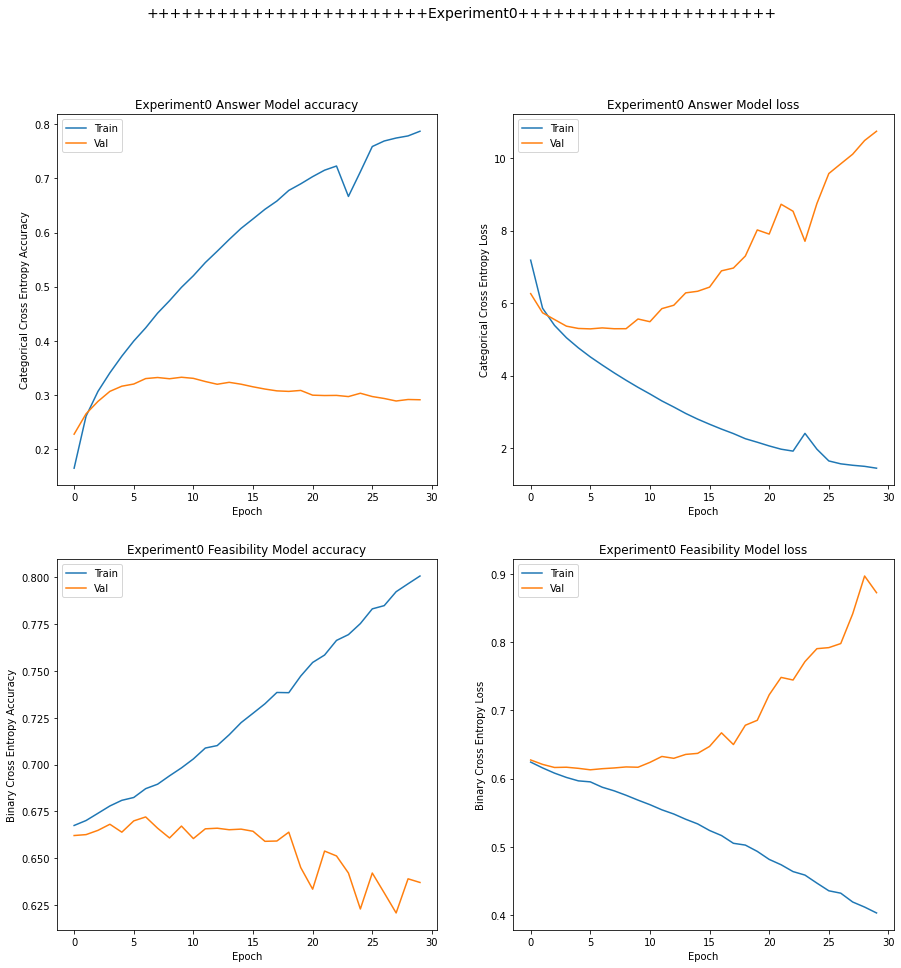

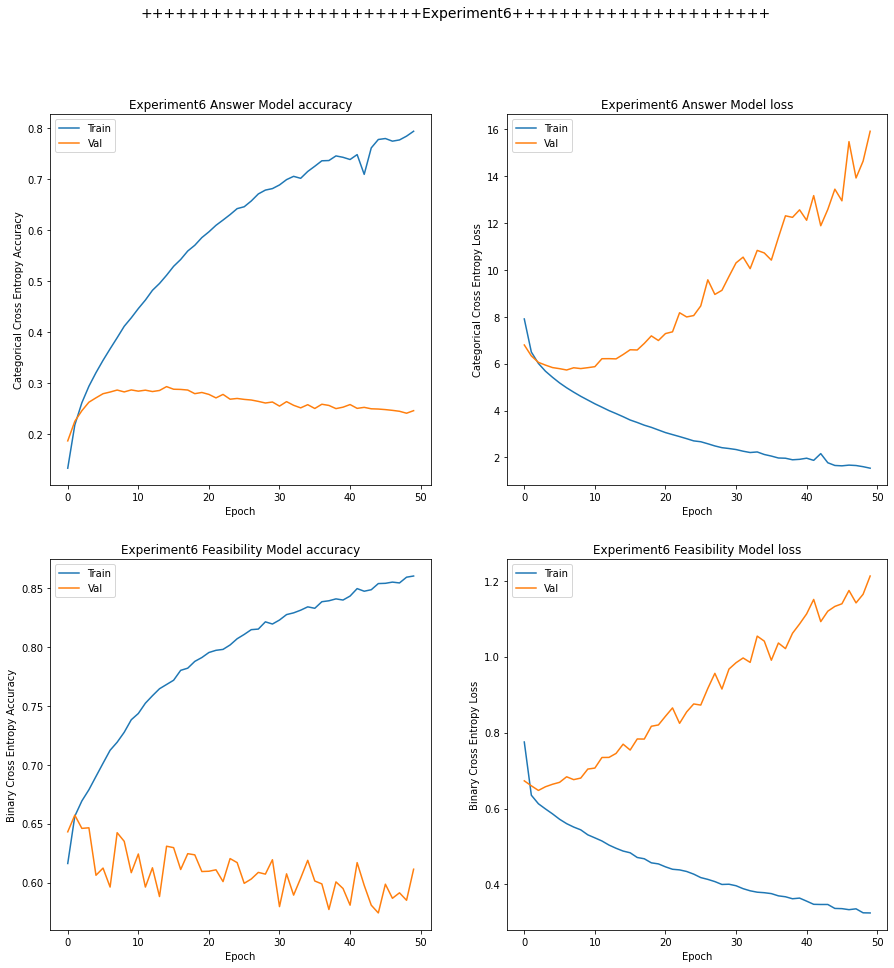

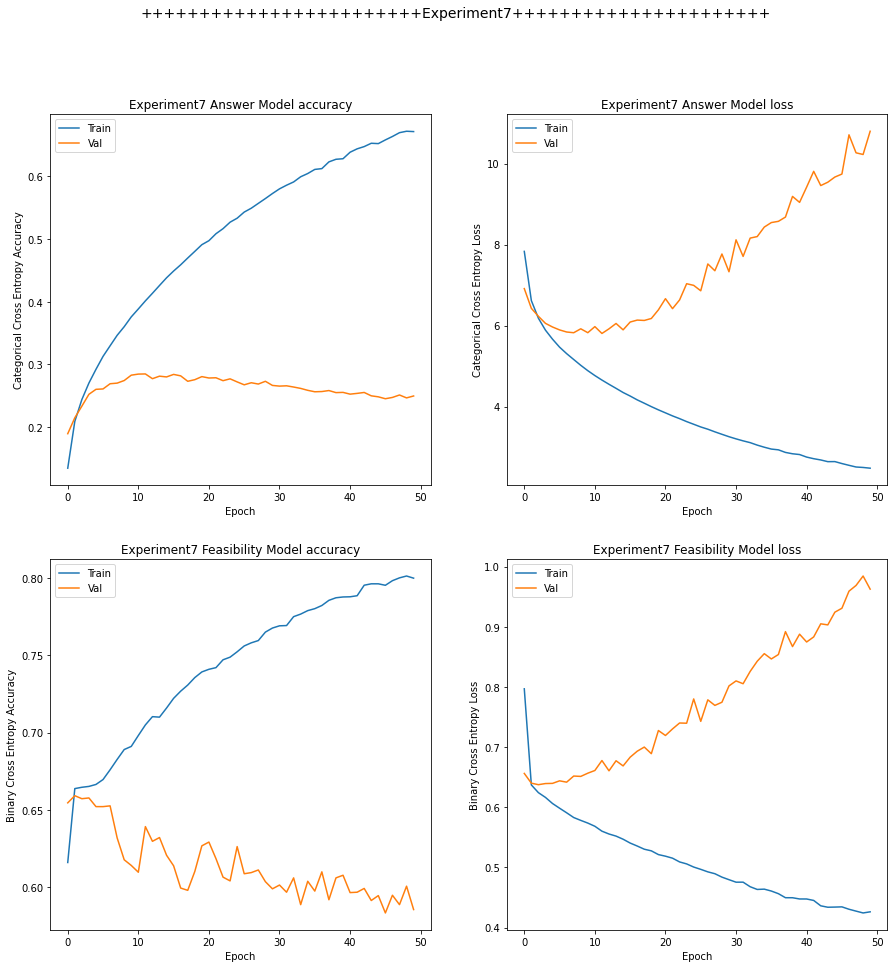

In [10]:
for i in range (8):
    plot_experiments(i)